In [1]:
import torch
import torch.nn as nn
import numpy as np
import h5py
from einops import rearrange, repeat, reduce

from flashdiv.flows.egnn_cutoff import EGNN_dynamics, EGNN_dynamicsPeriodic

from flashdiv.flows.flow_net_torchdiffeq import FlowNet
# from flashdiv.flows.message_passing import
from flashdiv.flows.trainer import FlowTrainer, FlowTrainerTorus

from pytorch_lightning import Trainer, LightningModule
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from pytorch_lightning import seed_everything
seed_everything(42)

import matplotlib.pyplot as plt
# try :
#    mystyle = '~/.config/matplotlib/rotskoff.mplstyle'
#    plt.style.use(mystyle)
# except :
#    mystyle = '/Users/jeremie/.matplotlib/rotskoff.mplstyle'
#    plt.style.use(mystyle)

# Example scripe

plt.rcParams.update({'text.usetex': True,
                     'font.family': 'CMU',
                     'text.latex.preamble': r'\usepackage{amsfonts}'})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2

Seed set to 42


# LJ model

In [2]:
from flashdiv.lj.lj import LJ

nparticles = 16
dim = 2
ljsystem= LJ(
  nparticles=nparticles,
  dim=dim,
  device='cuda',
  boxlength= nparticles ** (1 / dim),
  sigma=2 ** (-1 / 6),
  # shift=False,
  kT=1.0,
#   spring_constant = 0.05,
  periodic=True
)

In [3]:

def load_h5_to_tensor(h5_fname, dataset_name='trajectory', device='cuda'):
    with h5py.File(h5_fname, 'r') as h5f:
        data_np = h5f[dataset_name][:]
    data_tensor = torch.from_numpy(data_np).to(device)
    return data_tensor

# Example usage:
h5_fname = f'lj{nparticles}2d_mala_periodic_1.0.h5'
dataset_name = 'trajectory'
h5_data_tensor = load_h5_to_tensor(h5_fname, dataset_name=dataset_name, device=device)


In [58]:
gr_bins = np.linspace(0, 3, 50)
reflow_data = torch.load("data2/reflow_data.pt")
xt_reflow = reflow_data['xt']
x0_reflow = reflow_data['x0']
traj_reflow = reflow_data['traj']
logprob_reflow = reflow_data['log_prob']
xt_reflow_energy = ljsystem.potential(xt_reflow, turn_off_harmonic=True)
logweights = - 1 / ljsystem.kT * xt_reflow_energy - logprob_reflow
weights_reflow = torch.exp(logweights - torch.logsumexp(logweights, dim=0))

                                      
bins, xt_reflow_gr = ljsystem.g_r(xt_reflow, bins=gr_bins)
reflow_data_relaxed = torch.load("data2/reflow_data_filtered.pt")
xt_reflow_relaxed = reflow_data_relaxed['xt']
xt_reflow_relaxed_energy = ljsystem.potential(xt_reflow_relaxed,turn_off_harmonic=True)
_, xt_reflow_relaxed_gr = ljsystem.g_r(xt_reflow_relaxed, bins=gr_bins)
#final_data = torch.load("flow_model_learning_rate_0.0005_batch_size_256_nb_epochs_30_init_uniform_nn_egnn_reflow_True/reflow_data.pt")
final_data = torch.load("data/final_data.pt")
xt_final= final_data['xt']
x0_final = final_data['x0']
traj_final = final_data['traj']
logprob_final = final_data['log_prob']
xt_final_energy = ljsystem.potential(xt_final,turn_off_harmonic=True)
logweights_final = - 1 / ljsystem.kT * xt_final_energy - logprob_final
weights_final = torch.exp(logweights_final - torch.logsumexp(logweights_final, dim=0))
_, xt_final_gr = ljsystem.g_r(xt_final, bins=gr_bins)

target_data = h5_data_tensor[:10000]
target_data_energy = ljsystem.potential(target_data,turn_off_harmonic=True)
_, target_data_gr = ljsystem.g_r(target_data, bins=gr_bins)

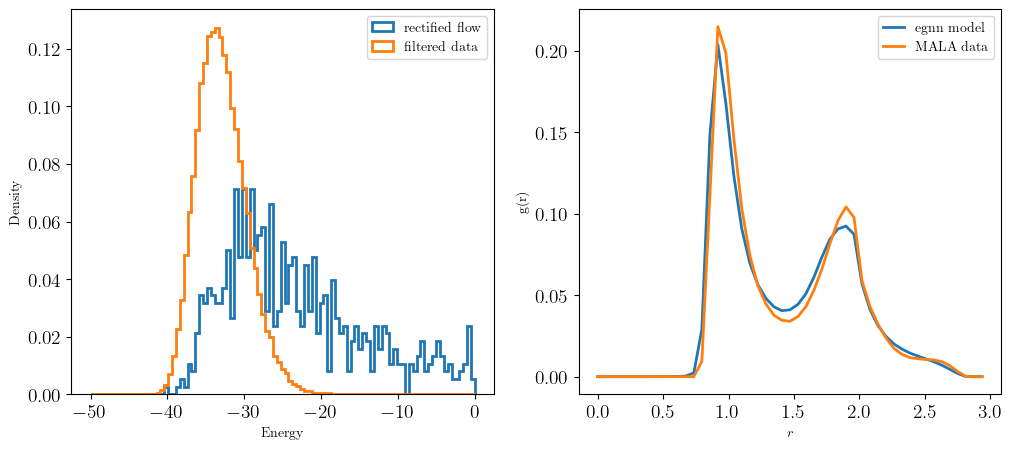

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
weights = torch.exp(-xt_final_energy/ljsystem.kT).cpu().numpy()
bins = np.linspace(-50, 0, 100)
#ax[0].hist(xt_reflow_energy[xt_reflow_energy < 0].cpu().numpy(),bins=bins, density=True, histtype='step', linewidth=2, label='egnn model')
#ax[0].hist(xt_reflow_energy[xt_reflow_energy < 0].cpu().numpy(), bins=bins, weights=weights_reflow[[xt_reflow_energy < 0]].cpu().numpy(), density=True, histtype='step', linewidth=2, label='egnn model- reweighted')
#ax[0].hist(target_data_energy.cpu().numpy(), bins=bins, density=True, histtype='step', linewidth=2, label='MALA data')
ax[0].hist(xt_final_energy[xt_final_energy<0].cpu().numpy(), bins=bins, density=True, histtype='step', linewidth=2, label='rectified flow')
ax[0].hist(xt_reflow_relaxed_energy[xt_reflow_relaxed_energy < 0].cpu().numpy(), bins=bins, density=True, histtype='step', linewidth=2, label='filtered data')
#ax[0].hist(xt_final_energy[xt_final_energy < 0].cpu().numpy(), bins=bins, weights=weights_final[[xt_final_energy < 0]].cpu().numpy(), density=True, histtype='step', linewidth=2, label='egnn model- reweighted')



ax[0].legend(handlelength=1.5, fontsize=10)
ax[0].set_xlabel(r'Energy')
ax[0].set_ylabel('Density')
ax[0].tick_params(labelsize=14)

ax[1].plot(gr_bins[:-1], xt_reflow_gr, label='egnn model', linewidth=2)
ax[1].plot(gr_bins[:-1], target_data_gr, label='MALA data', linewidth=2)
#ax[1].plot(gr_bins[:-1], xt_reflow_relaxed_gr, label='relaxed data', linewidth=2)
#ax[1].plot(gr_bins[:-1], xt_final_gr, label='refined model', linewidth=2)
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel('g(r)')
ax[1].legend(handlelength=1.5, fontsize=10)
ax[1].tick_params(labelsize=14)

In [17]:
# Load existing data
reflow_data = torch.load("data2/reflow_data.pt")
xt = reflow_data['xt']
x0 = reflow_data['x0']
logprob = reflow_data['log_prob']

# Compute energy and log weights
energy = ljsystem.potential(xt, turn_off_harmonic=True)
logw = -energy / ljsystem.kT - logprob

# Normalize log weights
logw_norm = logw - torch.logsumexp(logw, dim=0)
weights = torch.exp(logw_norm)

# First filter: weight < 0.005
mask = weights < 0.005
weights = weights[mask]
xt = xt[mask]
x0 = x0[mask]

# Second filter: remove weights < 1e-6
mask2 = weights >= 1e-6
weights = weights[mask2]
xt = xt[mask2]
x0 = x0[mask2]

# Re-normalize weights
weights /= weights.sum()

xt = xt-ljsystem.boxlength/2
x0 = x0-ljsystem.boxlength/2
# Save filtered data
filtered_data = {
    'xt': xt,
    'x0': x0,
    'importance_weights': weights,
}

torch.save(filtered_data, "data2/reflow_data_filtered.pt")

print(f"Saved {len(weights)} filtered samples to data2/reflow_data_filtered.pt")
out_file = "data2/reflow_data_filtered.h5"
with h5py.File(out_file, "w") as f:
    f.create_dataset("x0", data=x0.cpu().numpy(), compression="gzip")
    f.create_dataset("xt", data=xt.cpu().numpy(), compression="gzip")
    f.create_dataset("importance_weights", data=weights.cpu().numpy(), compression="gzip")


Saved 74389 filtered samples to data2/reflow_data_filtered.pt


In [44]:
print(xt[0,-1],xt_final[0,-1])
print(x0[0,-1],x0_final[0,-1])

tensor([-0.0348, -1.8125], device='cuda:0') tensor([-0.1309, -1.6133], device='cuda:0')
tensor([-0.3563, -1.4102], device='cuda:0') tensor([-0.3563, -1.4102], device='cuda:0')


In [40]:
x0_final[0]

tensor([[-1.5632,  0.4398],
        [-1.2998,  1.3626],
        [-1.9087, -1.0675],
        [-0.9837, -1.3331],
        [ 1.4819,  0.9148],
        [-1.5794,  1.2553],
        [-1.7157,  1.0805],
        [-1.3068,  1.4259],
        [ 0.9080, -0.4052],
        [ 1.9408, -0.1233],
        [-0.8955, -1.1629],
        [ 1.6814,  0.8509],
        [-0.9217,  1.2118],
        [ 0.5978, -0.9301],
        [ 0.4400, -0.6225],
        [-0.3563, -1.4102]], device='cuda:0')

In [28]:
nsamples= len(xt)
xt_new = h5_data_tensor[:nsamples].to(device)
x0_new, _ = ljsystem.sample_uniform(nsamples)
#concatenate data
xt_combined = torch.cat((xt_new, xt), dim=0)
x0_combined = torch.cat((x0_new, x0), dim=0)
importance_weights = torch.cat((torch.ones(nsamples, device=device), weights), dim=0)
torch.save({
    'xt': xt_combined,
    'x0': x0_combined,
    'importance_weights': importance_weights,
}, "data2/reflow_data_combined.pt")


In [27]:
x0_new.mean()

tensor(0.0003, device='cuda:0')

In [13]:
logweights = - 1 / ljsystem.kT * xt_reflow_energy - logprob_reflow
normalized_weights = torch.exp(logweights - torch.logsumexp(logweights, dim=0))
filter = normalized_weights < 0.0001
print(f"Number of samples with weight < 0.0001: {filter.sum().item()} out of {len(logweights)}")
def effective_sample_size(log_weights):
    """Kish effective sample size; log weights don't have to be normalized"""
    return (torch.exp(2*torch.logsumexp(log_weights, dim=0) - torch.logsumexp(2*log_weights, dim=0)))/len(log_weights)
normalized_weights = normalized_weights[filter]
normalized_weights = normalized_weights / torch.sum(normalized_weights)
ess = 1/ torch.sum(normalized_weights ** 2)/ len(normalized_weights)
print(f"Effective sample size: {ess.item()}")
print(f"Effective sample size: {effective_sample_size(logweights)}")

Number of samples with weight < 0.0001: 198892 out of 200000
Effective sample size: 0.13295739889144897
Effective sample size: 0.04452057555317879


Number of samples with energy < 0: 195334 out of 200000


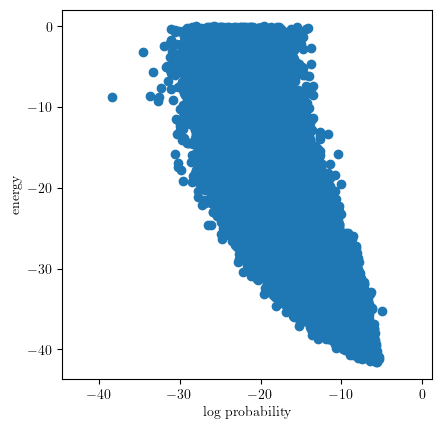

In [9]:
filter = xt_reflow_energy<0
print(f"Number of samples with energy < 0: {filter.sum().item()} out of {len(xt_reflow_energy)}")
plt.scatter(logprob_reflow[filter].cpu().numpy(), xt_reflow_energy[filter].cpu().numpy())
# Get current limits
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# Compute the ranges
xrange = xmax - xmin
yrange = ymax - ymin
max_range = max(xrange, yrange)

# Center each axis around its midpoint using the max range
xmid = (xmax + xmin) / 2
ymid = (ymax + ymin) / 2

plt.xlim(xmid - max_range / 2, xmid + max_range / 2)
plt.ylim(ymid - max_range / 2, ymid + max_range / 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("log probability")
plt.ylabel("energy")
plt.show()
plt.show()


In [14]:
    # # Optional: save results
    # torch.save({
    #     "sim_data": sim_data,
    #     "logprob": logprob_sim,
    #     "x0": x0
    # }, "data/simulation_logprob.pt")
simulation_logprob = torch.load("flow_model_learning_rate_0.0005_batch_size_256_nb_epochs_30_init_uniform_nn_egnn_reflow_False/simulation_logprob.pt")
sim_data = simulation_logprob['sim_data']
logprob_sim = simulation_logprob['logprob'][-1]
x0 = simulation_logprob['x0']
sim_energy = ljsystem.potential(sim_data, turn_off_harmonic=True)

In [51]:
logweights = - 1 / ljsystem.kT * xt_final_energy - logprob_final
normalized_weights = torch.exp(logweights - torch.logsumexp(logweights, dim=0))
filter = normalized_weights < 0.1
print(f"Number of samples with weight < 0.01: {filter.sum().item()} out of {len(logweights)}")
def effective_sample_size(log_weights):
    """Kish effective sample size; log weights don't have to be normalized"""
    return (torch.exp(2*torch.logsumexp(log_weights, dim=0) - torch.logsumexp(2*log_weights, dim=0)))/len(log_weights)

normalized_weights = normalized_weights[filter]
normalized_weights = normalized_weights / torch.sum(normalized_weights)
ess = 1/ torch.sum(normalized_weights ** 2)/ len(normalized_weights)
print(f"Effective sample size: {ess.item()}")
print(f"Effective sample size: {effective_sample_size(logweights[filter])}")


Number of samples with weight < 0.01: 1000 out of 1000
Effective sample size: 0.044020771980285645
Effective sample size: 0.044020798057317734


In [35]:
def plot_potential_vs_target_log_prob(potential, target_log_prob, weights):
    weights_norm = (weights / weights.sum()).cpu().numpy()
    print("max weights:", weights_norm.max().item())
    from matplotlib.colors import LogNorm
    sc = plt.scatter(target_log_prob.cpu().numpy(), potential.cpu().numpy(),c=weights_norm,cmap='coolwarm', norm=LogNorm())
    plt.colorbar(sc, label='Normalized Weight)')
    plt.xlabel("Target Log Probability")
    plt.ylabel("LJ Potential")
    plt.ylim(-50, 50)
    plt.show()

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_trajectory(xt, ljsystem, title=None, endpoints=None):
    """
    xt: Tensor of shape (nsteps, nparticles, 2)
    ljsystem: object with attribute `boxlength`
    """
    nsteps, nparticles, _ = xt.shape
    xt = xt % ljsystem.boxlength - ljsystem.boxlength / 2  # center
    if endpoints is not None:
        endpoints = endpoints % ljsystem.boxlength - ljsystem.boxlength / 2
    plt.figure(figsize=(8, 8))

    # Use a color map to assign distinct colors to particles
    cmap = plt.cm.get_cmap('hsv', nparticles)

    for i in range(nparticles):
        color = cmap(i)

        # Plot trajectory (intermediate steps) in muted color
        traj = xt[:, i]
        plt.scatter(
            traj[:, 0].cpu().numpy(),
            traj[:, 1].cpu().numpy(),
            color=color,
            s = 10,
        )

        # Highlight final position with a larger point
        final_pos = traj[-1]
        plt.scatter(
            final_pos[0].cpu().numpy(),
            final_pos[1].cpu().numpy(),
            color=color,
            edgecolor='k',
            s=20,
            zorder=3,
            label=f'Particle {i}'
        )
        if endpoints is not None:
            print(endpoints[i,0])
            plt.scatter(
                endpoints[i, 0].cpu().numpy(),
                endpoints[i, 1].cpu().numpy(),
                color=color,
                edgecolor='k',
                s=30,
                label=f'End {i}'
            )

    plt.xlim(-ljsystem.boxlength / 2, ljsystem.boxlength / 2)
    plt.ylim(-ljsystem.boxlength / 2, ljsystem.boxlength / 2)
    if title:
        plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.show()


/tmp/ipykernel_2627733/2585696589.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', nparticles)


tensor(0.8509, device='cuda:0')
tensor(0.8694, device='cuda:0')
tensor(-0.2707, device='cuda:0')
tensor(0.6576, device='cuda:0')
tensor(-0.9680, device='cuda:0')
tensor(0.1298, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(1.0148, device='cuda:0')
tensor(-0.9616, device='cuda:0')
tensor(-0.0122, device='cuda:0')
tensor(1.4984, device='cuda:0')
tensor(-0.9284, device='cuda:0')
tensor(1.8036, device='cuda:0')
tensor(-1.2939, device='cuda:0')
tensor(-1.8494, device='cuda:0')
tensor(1.9652, device='cuda:0')


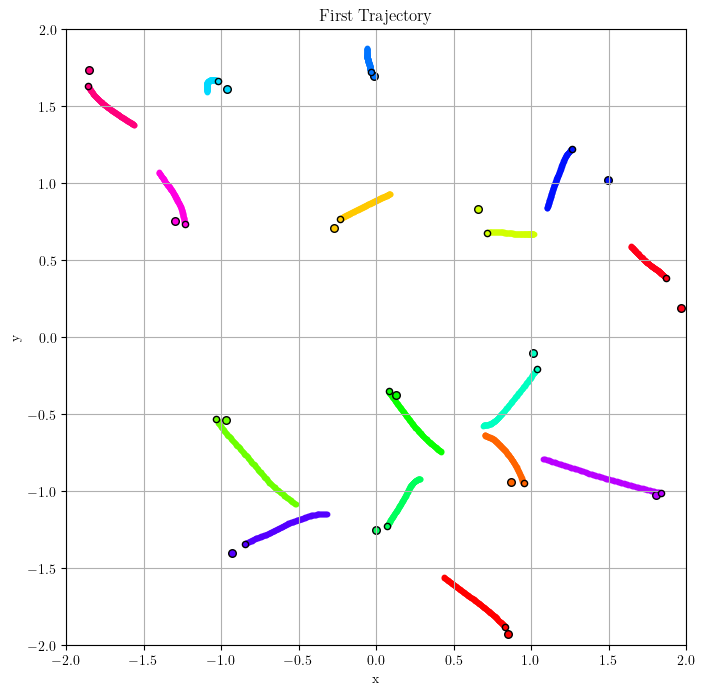

In [49]:
plot_trajectory(traj_final[0],ljsystem, title='First Trajectory', endpoints=xt[0])
#plot_trajectory(traj_final[0], ljsystem, title='Reflow Trajectory')

In [ ]:
_, g_r_1 = ljsystem.g_r(x0_reflow, bins=gr_bins)
_, g_r_2 = ljsystem.g_r(x0_final, bins=gr_bins) 

In [ ]:
plt.plot(bins[:-1], g_r_1, label='Reflow')
plt.plot(bins[:-1], g_r_2, label='Final')

In [ ]:
# Select a configuration to fix all particles except one
for idx, t_ in enumerate(times):

    if idx % 2 != 0:
        continue

    t_= t_.item()  # Get the time for the selected configuration
    fig, axs = plt.subplots(1,3,figsize=(18, 5))
    conf_idx = 0
    particle_idx = 4


    for ax in axs:
        # conf_idx +=1



        # Fix all other particles at their positions in xt[conf_idx]
        fixed_conf = xt_[idx][conf_idx].clone().detach() % ljsystem.boxlength  # shape: (nparticles, 2)
        nparticles = fixed_conf.shape[0]
        dim = fixed_conf.shape[1]

        # Define a grid for the selected particle
        x_min, x_max = 0, ljsystem.boxlength
        y_min, y_max = 0, ljsystem.boxlength
        n_grid = 30
        x_grid = torch.linspace(x_min, x_max, n_grid, device=fixed_conf.device)
        y_grid = torch.linspace(y_min, y_max, n_grid, device=fixed_conf.device)
        X, Y = torch.meshgrid(x_grid, y_grid, indexing='ij')
        positions = torch.stack([X, Y], dim=-1).reshape(-1, 2)  # (n_grid*n_grid, 2)

        # Prepare batch where all particles are fixed except the selected one
        batch = fixed_conf.unsqueeze(0).repeat(positions.shape[0], 1, 1)  # (n_grid*n_grid, nparticles, 2)
        batch[:, particle_idx, :] = positions  # vary only the selected particle

        # Compute the velocity field at t=0.5 (middle of the flow)
        t = torch.full((positions.shape[0], 1), t_, device=fixed_conf.device)

        with torch.no_grad():
            vel = velocitynet(batch, t)  # (n_grid*n_grid, nparticles, 2)
            vel_particle = vel[:, particle_idx, :].detach()  # (n_grid*n_grid, 2)
        strength = torch.norm(vel_particle, dim=-1).cpu().numpy()


        # Plot the quiver

        ax.quiver(
            positions[:, 0].cpu().numpy(),
            positions[:, 1].cpu().numpy(),
            vel_particle[:, 0].cpu().numpy(),
            vel_particle[:, 1].cpu().numpy(),
            strength,
            cmap='viridis',
            # scale=2,
            # alpha=0.8
            # angles='xy', scale_units='xy', scale=2.5, width=0.003, alpha=0.8
        )
        ax.scatter(
            fixed_conf[:, 0].cpu().numpy(),
            fixed_conf[:, 1].cpu().numpy(),s=60, label='Fixed particles'
        )
        ax.scatter(
            fixed_conf[particle_idx, 0].cpu().numpy(),
            fixed_conf[particle_idx, 1].cpu().numpy(),
            s=60, label='Tagged particle'
        )
        # initial positions of the particles
        ax.scatter(
            xt_[0][conf_idx][:, 0].cpu().detach(),  # shape: (nparticles, 2)[:, 0].cpu().numpy(),
            xt_[0][conf_idx][:, 1].cpu().numpy(),
            s=60, alpha=0.2, label='Grid points'
        )
        ax.set_title(f'time {t_}')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # ax.set_xlabel('x')
        # ax.set_ylabel('y')
        # plt.colorbar(label='Velocity magnitude')
        # ax.legend()
        # ax.axis('equal')
        particle_idx += 2

    fname = f'lj9_2d_egnn_samples_{0.3}_flow_field_t{t_:.2f}.png'
    # plt.savefig(f'figures/{fname}', bbox_inches='tight')
    # plt.show()

In [ ]:
def wrap_displacement(displacement, boxlength):
    """
    Wraps the displacement to be within the box length.
    """
    return displacement - boxlength * torch.round(displacement / boxlength)

In [ ]:
boxlength = ljsystem.boxlength
trained_displacement = wrap_displacement(xt_reflow - x0_reflow, boxlength)
trained_displacement_norm = torch.norm(trained_displacement, dim=-1)
print("average displacement norm:", trained_displacement_norm.mean().item())

In [ ]:
rand_displacement = h5_data_tensor[:x0_reflow.shape[0]] - x0_reflow
rand_displacement = wrap_displacement(rand_displacement, boxlength)
rand_displacement_norm = torch.norm(rand_displacement, dim=-1)
print("average displacement norm:", rand_displacement_norm.mean().item())

In [ ]:
reflow_displacement = wrap_displacement(xt_final - x0_final, boxlength)
reflow_displacement_norm = torch.norm(reflow_displacement, dim=-1)
print("average displacement norm:", reflow_displacement_norm.mean().item())

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

bins = np.linspace(-50, 20, 100)
ax[0].hist(xt_reflow_energy[xt_reflow_energy < 1000].cpu().numpy(),bins=bins, density=True, histtype='step', linewidth=2, label='Generated data')
ax[0].hist(target_data_energy.cpu().numpy(), bins=bins, density=True, histtype='step', linewidth=2, label='MALA data')

ax[0].legend(handlelength=1.5, fontsize=10)
ax[0].set_xlabel(r'Energy')
ax[0].set_ylabel('Density')
ax[0].tick_params(labelsize=14)

ax[1].plot(gr_bins[:-1], xt_reflow_gr, label='Generated data', linewidth=2)
ax[1].plot(gr_bins[:-1], target_data_gr, label='MALA data', linewidth=2)
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel('g(r)')
ax[1].legend(handlelength=1.5, fontsize=10)
ax[1].tick_params(labelsize=14)

# train model

In [ ]:


hidden_nf = 32
nlayers = 3
cutoff = 10.0
max_neighbors = 14


velocitynet = EGNN_dynamicsPeriodic(
    n_particles= ljsystem.nparticles - 1,
    device='cuda',
    n_dimension=ljsystem.dim,
    hidden_nf=hidden_nf,
    act_fn=torch.nn.SiLU(),
    n_layers=nlayers,
    recurrent=True,
    tanh=True,
    attention=True,
    condition_time=True,
    out_node_nf=8,
    mode='egnn_dynamics',
    agg='sum',
    cutoff=cutoff,
    boxlength=ljsystem.boxlength,
    max_neighbors=max_neighbors
    ).to(device)


velocitynet.to(device)


In [ ]:
lr = 5e-4
nb_epochs = 30

velocitytrainer = FlowTrainerTorus(velocitynet, learning_rate=lr, sigma=0.001, boxlength=ljsystem.boxlength)


trainer = Trainer(
    max_epochs=nb_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    default_root_dir=f'.',
    enable_progress_bar = True,
    )

trainer.fit(velocitytrainer, train_loader, val_loader)

# or load model

In [ ]:
ljsystem.nparticles

In [ ]:
cutoff = 10.0
max_neighbors = 10
hidden_nf = 32
velocitynet = EGNN_dynamicsPeriodic(
    n_particles= ljsystem.nparticles - 1,
    device='cuda',
    n_dimension=ljsystem.dim,
    hidden_nf=hidden_nf,
    act_fn=torch.nn.SiLU(),
    n_layers=3,
    recurrent=True,
    tanh=True,
    attention=True,
    condition_time=True,
    out_node_nf=8,
    mode='egnn_dynamics',
    agg='sum',
    cutoff=cutoff,
    max_neighbors=max_neighbors
    ).to(device)


velocitynet.to(device)

velocitytrainer = FlowTrainerTorus.load_from_checkpoint(
    # '../create_lj9_periodic_data/lightning_logs/version_11/checkpoints/epoch=99-step=62500.ckpt',
    '../create_lj9_periodic_data/lightning_logs/version_2/checkpoints/epoch=99-step=62500.ckpt',
    # '../create_lj9_periodic_data/lightning_logs/version_11/checkpoints/epoch=49-step=15650.ckpt',
    # '../20250901_lj_162d_periodic/flow_model_learning_rate_0.0005_batch_size_256_nb_epochs_100_hidden_dim_32_nb_layers_3_cutoff_10.0_max_neighbors_10_nbsamples_1000000/lightning_logs/version_1920937/checkpoints/epoch=99-step=312500.ckpt',
    # 'lightning_logs/version_11/checkpoints/epoch=149-step=46950.ckpt',
    flow_model = velocitynet)

velocitynet = velocitytrainer.flow_model.eval().to(device)

# inference 

In [ ]:
velocitynet.to(device)
batch_size = 1000
nparticles = ljsystem.nparticles
dim = ljsystem.dim
scale = 1.0
xt = []
xinit = []
all_xt = []
all_logprob = []
target_log_prob = []
source_log_prob = []


x0_, _ = ljsystem.sample_wrapped_gaussian(std = std, size = batch_size, device=device)
# permute randomly
perm = torch.stack([torch.randperm(ljsystem.nparticles) for _ in range(x0_.shape[0])])
idx = torch.arange(x0_.shape[0]).unsqueeze(-1).expand(x0_.shape[0], ljsystem.nparticles)
x0 = x0_[idx, perm, :]

# torch.randn(batch_size, nparticles, dim, dtype=torch.float32).to(device) * scale
# x0 -= x0.mean(dim=1, keepdim=True)  # center the particles

source_log_prob0 = -(x0 ** 2).sum((1,2)) / (2.0 * scale)  # Gaussian log probability before the recentering not true for now but doesn't matter

times = torch.linspace(0,1,2).to(x0)
all_xt= velocitynet.sample(
# all_xt, all_logprob= velocitynet.sample_logprob(
    x0,
    # source_log_prob0,
    times,
    # div_method='direct_trace',
    # div_method='hutch',
    # div_samples=10,
    method='rk4',
    # boxlength=ljsystem.boxlength,
    # method='dopri5',
    options = {
        'step_size': 1 / 40,
        # 'max_num_steps': int(1e3)
        }
    )


msgpassing_data = {
    'xt': all_xt[-1],
    'xinit': all_xt[-0],
    'all_xt': all_xt,
    # 'all_logprob': all_logprob,
    # 'target_log_prob': all_logprob[-1],
    # 'source_log_prob': all_logprob[0]
}

In [ ]:
def run_MALA(target, x_init, n_steps, dt, adaptive=True,
             save_every=100,burn_in=0, xs=None, center_com=False):
    '''
    target: target with the potentiel we will run the langevin on
    -> needs to have force function implemented
    x (tensor): init points for the chains to update (batch_dim, dim)
    dt -> is multiplied by N for the phiFour before being passed
    '''
    print("Running MALA")
    acc = 0
    idx = 0
    pot_list = []
    if xs is None:
        xs = torch.zeros((n_steps//save_every, x_init.shape[0], x_init.shape[1], x_init.shape[2]), device=x_init.device)
    force_current = target.force(x_init)
    potential_current = target.potential(x_init)
    x = x_init
    for i in range(n_steps+burn_in):
        x_new = x + dt * force_current
        x_new = x_new + np.sqrt(2 * dt * target.kT) * torch.randn_like(x)
        potential_new = target.potential(x_new)
        ratio = potential_current - potential_new
        if i<burn_in:
            pot_list.append(potential_current[0].clone())
        force_new = target.force(x_new)
        ratio -= ((x - x_new - dt * force_new) ** 2 / (4 * dt)).sum((1,2))
        ratio += ((x_new - x - dt * force_current) ** 2 / (4 * dt)).sum((1,2))
        ratio = 1/target.kT * ratio
        ratio = torch.exp(ratio)
        u = torch.rand_like(ratio)
        acc_i = u < torch.min(ratio, torch.ones_like(ratio))
        x[acc_i] = x_new[acc_i]
        force_current[acc_i] = force_new[acc_i]
        potential_current[acc_i] = potential_new[acc_i]
        acc += acc_i.float().mean()
        if i >= burn_in and (i-burn_in) % save_every == 0:
            if center_com:
                # Center the center of mass
                com = x.mean(dim=1, keepdim=True)
                x -= com
            print(idx)
            xs[idx] = x
            idx += 1
        if (i < burn_in) and (i % save_every) == 0:
            acc_rate = acc/(i+1)
            if adaptive:
                if acc_rate <0.3:
                    dt *= 1 - 0.5*(0.3-acc_rate.detach().cpu().numpy())
                elif acc_rate >0.5:
                    dt *= 1 + 0.5*(acc_rate.detach().cpu().numpy()-0.5)
        if (i % save_every) == 0:
            print("Step %d, dt %.6f"%(i, dt))
    return xs

In [ ]:
init = msgpassing_data['xinit']
xt = msgpassing_data['xt']
xt_copy = xt.clone()


In [ ]:
xt_relaxed = run_MALA(ljsystem,xt_copy,n_steps=100,dt=0.001, burn_in=30,save_every=5)

In [ ]:
displacement = xt_relaxed[-1] - xt_relaxed[0]
print("average displacement:", displacement.norm(dim=-1).mean())

In [ ]:
last_frame = xt_relaxed[-1]

In [ ]:
msgpassing_energy_relaxed = ljsystem.potential(last_frame, turn_off_harmonic=True).cpu().numpy()

## look at energies and dists